In [5]:
import os
import glob
import json
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, matthews_corrcoef,fbeta_score, f1_score
from similarityregression.PredictSimilarity import ReadSRModel

WorkingOn = 'DNA'

BaselineMethod = 'PctID_L'

#Should models with windowed feature smoothing be accepted?
AllowSmooth = False
AllowSmooth_Exemptions = set() #['F091_1.97d']

loc_ModelPerformances = glob.glob(WorkingOn + '/ByFamily/*/Models/PRThresholdData.csv')

tf_families = pd.read_csv('../CisBP/' + WorkingOn + '/DBFiles/tf_families.tab', sep = '\t', skiprows = [1], index_col=0)
tf_families = tf_families.rename(index=str, columns={"Cutoff": "CisBP_Cutoff"})

for loc_ModelPerformance in loc_ModelPerformances:
    FID = loc_ModelPerformance.split('/')[2]
    loc_YSim = loc_ModelPerformance.replace('Models/PRThresholdData.csv', 'TrainingData/Y_Sims_PctID.csv.gz')
    try:
        YSims = pd.read_csv(loc_YSim, compression='gzip')
        tf_families.loc[FID, 'NumberOfPairs'] = YSims.shape[0]
        tf_families.loc[FID, 'Experiments'] = len(set(list(YSims['MID_x']) + list(YSims['MID_y'])))
    except:
        continue

# Parse/Calculate SR performance metrics 
Metrics = [Precision, Recall, MCC, F1 (micro/macro)]

In [13]:
MulticlassPerformances = []
ConfusionMats = {}

for loc_ModelPerformance in loc_ModelPerformances:
    FID = loc_ModelPerformance.split('/')[2]
    ConfusionMats[FID]= {}
    print FID
    #Preds/Labels (Training)
    Preds = pd.read_csv(WorkingOn + '/ByFamily/' + FID + '/Models/Predictions_TestSet.csv')
    Y = pd.read_csv(WorkingOn + '/ByFamily/' + FID + '/TrainingData/Y_Sims_PctID.csv.gz')
    Y['TN'] = Y['EScoreOverlap'] >= 0.2
    Y['TN'] = Y.TN.astype(int)
    
    #Preds/Labels (Final)
    FinalPreds = pd.read_csv(WorkingOn + '/ByFamily/' + FID + '/Models/Predictions_FinalModel.csv')
    
    #Assign True Labels
    Preds['True'] = 'Amb'
    Preds.loc[Preds['EClass'] == 1, 'True'] = 'HS' 
    Preds.loc[Preds['TN'] == 0, 'True'] = 'Dis' 
    Y['True'] = 'Amb'
    Y.loc[Y['EClass'] == 1, 'True'] = 'HS' 
    Y.loc[Y['TN'] == 0, 'True'] = 'Dis'
    FinalPreds['True'] = 'Amb'
    FinalPreds.loc[FinalPreds['Class'] == 1, 'True'] = 'HS' 
    FinalPreds.loc[FinalPreds['TN'] == 0, 'True'] = 'Dis' 
    
    #Positives
    Performances = pd.read_csv(loc_ModelPerformance)
    Performances = Performances[Performances['Model'] != 'PctID_S']
    if (AllowSmooth == False) and (FID not in AllowSmooth_Exemptions):
        Performances = Performances.loc[['Smooth' not in x for x in Performances['Model']],]
    
    #Negatives
    NPerformances = pd.read_csv(loc_ModelPerformance.replace('PRThresholdData', 'NPVThresholdData'))
    
    for method in set(Performances['Model']):
        #Get Positive Info
        Performances_HSim = Performances[(Performances['Model'] == method) &
                                         (Performances['Precision_TEST'] >= 0.75) &
                                         (Performances['Threshold'].isnull() == False)]
        if Performances_HSim.shape[0] >= 1:
            Performances_HSim_Selected = Performances_HSim.iloc[0]
            thresh_class = Performances_HSim_Selected['Threshold']
        else:
            thresh_class = None
        
        #Get Negative Info
        NPerformances_Dis = NPerformances[(NPerformances['Model'] == method) &
                                          (NPerformances['NPV_Target'] >= 0.95) &
                                          (NPerformances['Threshold'] < thresh_class)]
        if NPerformances_Dis.shape[0] >= 1:
            NPerformances_Dis_Selected = NPerformances_Dis.iloc[0]
            thresh_tn = NPerformances_Dis_Selected['Threshold']
        else:
            thresh_tn = None
            
        #print FID, method, thresh_class, thresh_tn

        if 'PctID_' in method:
            cpreds = Y[[method, 'True']].copy()
            cpreds.columns = ['Score', 'True']
            fpreds = cpreds.copy()
        else:
            cpreds = Preds[[method, 'True']].copy()
            cpreds.columns = ['Score', 'True']
            fpreds = FinalPreds[[method, 'True']].copy()
            fpreds.columns = ['Score', 'True']
            
        #Assign Predicted Labels (LOCO-CV Micro-Performance)
        cpreds['Predicted'] = 'Amb'
        if thresh_class != None:
            cpreds.loc[cpreds['Score'] > thresh_class, 'Predicted'] = 'HS' 
        if thresh_tn != None:
            cpreds.loc[cpreds['Score'] < thresh_tn, 'Predicted'] = 'Dis'
        
        cm = confusion_matrix(cpreds['True'], cpreds['Predicted'], labels=["HS", "Amb", "Dis"])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        MCC = matthews_corrcoef(cpreds['True'], cpreds['Predicted'])
        F1_macro = fbeta_score(cpreds['True'], cpreds['Predicted'], average='macro', beta=1)
        F1_micro = fbeta_score(cpreds['True'], cpreds['Predicted'], average='micro', beta=1)
        #print FID, method, MCC, F1_macro, F1_micro
        
        #Assign Predicted Labels (Final Model Performance (all data))
        fpreds['Predicted'] = 'Amb'
        fpreds.loc[fpreds['Score'] > thresh_class, 'Predicted'] = 'HS' 
        fpreds.loc[fpreds['Score'] < thresh_tn, 'Predicted'] = 'Dis'
        final_cm = confusion_matrix(fpreds['True'], fpreds['Predicted'], labels=["HS", "Amb", "Dis"])
        final_cm_normalized = final_cm.astype('float') / final_cm.sum(axis=1)[:, np.newaxis]
        final_MCC = matthews_corrcoef(fpreds['True'], fpreds['Predicted'])
        final_F1_macro = fbeta_score(fpreds['True'], fpreds['Predicted'], average='macro', beta=1)
        final_F1_micro = fbeta_score(fpreds['True'], fpreds['Predicted'], average='micro', beta=1)
        
        #print FID, method, MCC, final_MCC, F1_macro, final_F1_macro, F1_micro, final_F1_micro
        performancestats = [FID, method, MCC, final_MCC, F1_macro, final_F1_macro, F1_micro, final_F1_micro]
        if thresh_class != None:
            performancestats += [Performances_HSim_Selected['Recall_TEST'], Performances_HSim_Selected['Recall_FINAL']]
        else:
            performancestats += [np.nan, np.nan]
        
        if thresh_tn != None:
            performancestats += [NPerformances_Dis_Selected['NegativeRecall_TEST'], NPerformances_Dis_Selected['NegativeRecall_FINAL']]
        else:
            performancestats += [np.nan, np.nan]
        
        performancestats += [thresh_class, thresh_tn]
        MulticlassPerformances.append(performancestats)
        ConfusionMats[FID][method] = {'Raw.Test': cm, 'Raw.Final':final_cm, 'Norm.Test':cm_normalized, 'Norm.Final':final_cm_normalized}

MulticlassPerformances = pd.DataFrame(MulticlassPerformances, columns=['FID', 'Model', 'MCC_TEST', 'MCC_FINAL', 'F1macro_TEST', 'F1macro_FINAL', 'F1micro_TEST', 'F1micro_FINAL', 
                                                                       'Recall_TEST', 'Recall_FINAL', 'NegativeRecall_TEST', 'NegativeRecall_FINAL', 'Thresh_HSim', 'Thresh_Dis'])
MulticlassPerformances = MulticlassPerformances.sort_values(['FID', 'MCC_TEST'], ascending=[True,False])
MulticlassPerformances['Family_Name'] = [tf_families['Family_Name'].get(x) for x in MulticlassPerformances['FID']]

#Select Best Models by MCC Train
MulticlassPerformances.loc[MulticlassPerformances['Model'] == BaselineMethod, 'ModelSelection'] = 'BaselineMethod'
for FID, data in MulticlassPerformances.groupby('FID'):
    MulticlassPerformances.loc[data.index,'Model.Rank'] = range(1,data.shape[0] + 1) 
    data = data[(data['Model'] != BaselineMethod) & (data['Thresh_HSim'].isnull() == False)]
    if data.shape[0] > 0:
        MulticlassPerformances.loc[data.index[0], 'ModelSelection'] = 'SR'
MulticlassPerformances.to_csv('MulticlassPerformances_All.csv', index=False)

F009_1.97d
F026_1.97d
F028_1.97d
F039_1.97d
F082_1.97d
F091_1.97d
F135_1.97d
F169_1.97d
F170_1.97d
F173_1.97d


/Users/slambert/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in divide
/Users/slambert/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in divide


F174_1.97d
F180_1.97d
F196_1.97d
F201_1.97d
F212_1.97d
F223_1.97d
F231_1.97d
F238_1.97d
F243_1.97d
F251_1.97d
F266_1.97d
F273_1.97d
F278_1.97d
F282_1.97d
F294_1.97d
F299_1.97d
F301_1.97d
F305_1.97d
F312_1.97d
F314_1.97d
F315_1.97d
F323_1.97d
F324_1.97d


# Parse Best SR Models -> Scoring Files
### Use %ID when SR is worse

In [14]:
if os.path.isdir(WorkingOn + '/SRModels') == False:
    os.mkdir(WorkingOn + '/SRModels')
    
Overides_ModelSelection = {'F170_1.97d' : 'AvgB62.Logistic'}

In [15]:
for FID, data in MulticlassPerformances.groupby('FID'):
    data = data[data['Thresh_HSim'].isnull() == False]
    #Find the best model
    if data.shape[0] > 0:
        if FID in Overides_ModelSelection:
            SelectedModel = Overides_ModelSelection[FID]
            dSM = data[data['Model'] == SelectedModel]
            dSM = dSM.iloc[0,]
        else:
            dSM = data.iloc[0,]
            SelectedModel = dSM['Model']
    else:
        SelectedModel = None
    
    #Initialize container for selected SR/Alignment model
    ScoringModel = {}
    #Output Data
    if SelectedModel != None:
        tf_families.loc[FID, 'Model'] = SelectedModel
        ScoringModel['Family_ID'] =  FID
        ScoringModel['Family_Name'] =  dSM['Family_Name']
        if SelectedModel == 'PctID_L':
            ScoringModel['Model.Name'] = 'PctID_L'
            ScoringModel['Model.Class'] = 'SequenceIdentity'
            ScoringModel['Threshold.HSim'] = dSM['Thresh_HSim']
            ScoringModel['Threshold.Dis'] = dSM['Thresh_Dis']
        else:
            #Add PctID_L as the Baseline.Method into the scoring file
            BaselineModel = data.loc[data['ModelSelection'] == 'BaselineMethod',]
            BaselineModel = BaselineModel.iloc[0,]
            ScoringModel['Baseline'] = {}
            ScoringModel['Baseline']['Name'] = 'PctID_L'
            ScoringModel['Baseline']['Class'] = 'SequenceIdentity'
            ScoringModel['Baseline']['Threshold.HSim'] = BaselineModel['Thresh_HSim']
            ScoringModel['Baseline']['Threshold.Dis'] = BaselineModel['Thresh_Dis']
            
            #Add other model information
            ScoringModel['Model.Name'] = SelectedModel
            ScoringModel['Model.Class'] = 'SimilarityRegression'
            ScoringModel['SR.Features'] = SelectedModel.split('.')[0].replace(' (Smooth3)', '_Smooth3') #For Heldout files
            if SelectedModel.split('.')[1] == 'Logistic':
                ScoringModel['SR.LogisticTransform'] = True
            else:
                ScoringModel['SR.LogisticTransform'] = False
            ScoringModel['Threshold.HSim'] = dSM['Thresh_HSim']
            ScoringModel['Threshold.Dis'] = dSM['Thresh_Dis']
            #Read weights
            SRCoefs = pd.read_csv(WorkingOn + '/ByFamily/' + FID + '/Models/ModelCoefficents.csv', index_col=0)
            SRCoefs = SRCoefs[SelectedModel]
            ScoringModel['SR.Intercept'] = SRCoefs[0]
            ScoringModel['SR.Weights'] = list(SRCoefs[1:])
            #Read feature scaling (mean/sd)
            SRXscales = pd.read_csv(WorkingOn + '/ByFamily/' + FID + '/Models/XScales.csv', index_col=[1,2])
            SRXscales = SRXscales.iloc[:,1:] #Drop weird index column
            SRXscales = SRXscales.loc[SelectedModel.split('.')[0],]
            ScoringModel['SR.FeatureScales.mean'] = list(SRXscales.loc['mean',])
            ScoringModel['SR.FeatureScales.sd'] = list(SRXscales.loc['sd',])
        #Output
        with open(WorkingOn + '/SRModels/' + FID + '.json', 'w') as loc_FamilySRModel:
            loc_FamilySRModel.write(json.dumps(ScoringModel, indent = 4, sort_keys= True))

/Users/slambert/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:55: PerformanceWarning: indexing past lexsort depth may impact performance.


## Select score threshold for families without SR models

In [227]:
SRmodels = glob.glob(WorkingOn + '/SRModels/*.json')
YSims = glob.glob(WorkingOn + '/ByFamily/*/TrainingData/Y_Sims_PctID.csv.gz')

FID_HasModel = set()

cutoffs_HSim = {}
cutoffs_Dis = {}
cutoffs_Dis_repNA = {}
mediancutoff_Dis_repNAtoMin = {}
for loc_SRmodel in SRmodels:
    SRmodel = ReadSRModel(loc_SRmodel)
    FID = SRmodel['Family_ID']
    FID_HasModel.add(FID)
    if SRmodel['Model.Class'] == 'SequenceIdentity':
        cutoffs_HSim[FID] = SRmodel['Threshold.HSim']
        if pd.isnull(SRmodel['Threshold.Dis']) == False:
            cutoffs_Dis[FID] = SRmodel['Threshold.Dis']
            cutoffs_Dis_repNA[FID] = SRmodel['Threshold.Dis']
            mediancutoff_Dis_repNAtoMin[FID] = SRmodel['Threshold.Dis']
        else:
            cutoffs_Dis_repNA[FID] = 0
            cY = pd.read_csv(WorkingOn + '/ByFamily/%s/TrainingData/Y_Sims_PctID.csv.gz'%FID, compression='gzip')
            mediancutoff_Dis_repNAtoMin[FID] = cY['PctID_L'].min()
    else:
        cutoffs_HSim[FID] = SRmodel['Baseline']['Threshold.HSim']
        if pd.isnull(SRmodel['Baseline']['Threshold.Dis']) == False:
            cutoffs_Dis[FID] = SRmodel['Baseline']['Threshold.Dis']
            cutoffs_Dis_repNA[FID] = SRmodel['Baseline']['Threshold.Dis']
            mediancutoff_Dis_repNAtoMin[FID] = SRmodel['Threshold.Dis']
        else:
            cutoffs_Dis_repNA[FID] = 0
            cY = pd.read_csv(WorkingOn + '/ByFamily/%s/TrainingData/Y_Sims_PctID.csv.gz'%FID, compression='gzip')
            mediancutoff_Dis_repNAtoMin[FID] = cY['PctID_L'].min()
        
mediancutoff_HSim = np.median(cutoffs_HSim.values())
mediancutoff_Dis = np.median(cutoffs_Dis.values())
mediancutoff_Dis_repNA = np.median(cutoffs_Dis_repNA.values())
mediancutoff_Dis_repNAtoMin = np.median(mediancutoff_Dis_repNAtoMin.values())

In [210]:
#Read Y_Sims

count_HasModel = 0
count_NoModel = 0

for loc_YSim in YSims:
    FID = loc_YSim.split('/')[2]
    if FID in FID_HasModel:
        count_HasModel += 1
        if count_HasModel == 1:
            Y_HasModel = pd.read_csv(loc_YSim, compression='gzip')
            Y_HasModel['Family_ID'] = FID
        else:
            cY = pd.read_csv(loc_YSim, compression='gzip')
            cY['Family_ID'] = FID
            Y_HasModel = pd.concat([Y_HasModel, cY])
    else:
        count_NoModel += 1
        if count_NoModel == 1:
            try:
                Y_NoModel = pd.read_csv(loc_YSim, compression='gzip')
                Y_NoModel['Family_ID'] = FID
            except:
                count_NoModel -= 1
        else:
            try:
                cY = pd.read_csv(loc_YSim, compression='gzip')
                cY['Family_ID'] = FID
                Y_NoModel = pd.concat([Y_NoModel, cY])
            except:
                count_NoModel -= 1

Y_HasModel['TN'] = 1.0*(Y_HasModel['EScoreOverlap'] <= 0.2)
Y_NoModel['TN'] = 1.0*(Y_NoModel['EScoreOverlap'] <= 0.2)

Y_NoModel_Positive = Y_NoModel[Y_NoModel['EClass'].isnull() == False]

Y_All = pd.concat([Y_HasModel, Y_NoModel])
Y_All_Positive = Y_All[Y_All['EClass'].isnull() == False]

## Use Median Cutoffs

In [218]:
print '%ID THRESHOLDS', '| HSim: %f'%mediancutoff_HSim, '| Dis: %f'%mediancutoff_Dis, '| Dis (Na to 0): %f'%mediancutoff_Dis_repNA
 
# Try HSim cutoffs 
HasModel_Positive_Precision = Y_HasModel[Y_HasModel['PctID_L'] >= mediancutoff_HSim]['EClass'].mean()
HasModel_Positive_Recall = Y_HasModel[Y_HasModel['PctID_L'] >= mediancutoff_HSim]['EClass'].sum()/Y_HasModel['EClass'].sum()

NoModel_Positive_Precision = Y_NoModel_Positive[Y_NoModel_Positive['PctID_L'] >= mediancutoff_HSim]['EClass'].mean()
NoModel_Positive_Recall = Y_NoModel_Positive[Y_NoModel_Positive['PctID_L'] >= mediancutoff_HSim]['EClass'].sum()/Y_NoModel_Positive['EClass'].sum()

All_Positive_Precision = Y_All_Positive[Y_All_Positive['PctID_L'] >= mediancutoff_HSim]['EClass'].mean()
All_Positive_Recall = Y_All_Positive[Y_All_Positive['PctID_L'] >= mediancutoff_HSim]['EClass'].sum()/Y_All_Positive['EClass'].sum()

# Try Dis cutoffs
HasModel_Negative_Precision = Y_HasModel[Y_HasModel['PctID_L'] < mediancutoff_Dis]['TN'].mean()
HasModel_Negative_Recall = Y_HasModel[Y_HasModel['PctID_L'] < mediancutoff_Dis]['TN'].sum()/Y_HasModel['TN'].sum()
HasModel_Negative_Precision_repNA = Y_HasModel[Y_HasModel['PctID_L'] < mediancutoff_Dis_repNA]['TN'].mean()
HasModel_Negative_Recall_repNA = Y_HasModel[Y_HasModel['PctID_L'] < mediancutoff_Dis_repNA]['TN'].sum()/Y_HasModel['TN'].sum()

NoModel_Negative_Precision = Y_NoModel[Y_NoModel['PctID_L'] < mediancutoff_Dis]['TN'].mean()
NoModel_Negative_Recall = Y_NoModel[Y_NoModel['PctID_L'] < mediancutoff_Dis]['TN'].sum()/Y_NoModel['TN'].sum()
NoModel_Negative_Precision_repNA = Y_NoModel[Y_NoModel['PctID_L'] < mediancutoff_Dis_repNA]['TN'].mean()
NoModel_Negative_Recall_repNA = Y_NoModel[Y_NoModel['PctID_L'] < mediancutoff_Dis_repNA]['TN'].sum()/Y_NoModel['TN'].sum()

All_Negative_Precision = Y_All[Y_All['PctID_L'] < mediancutoff_Dis]['TN'].mean()
All_Negative_Recall = Y_All[Y_All['PctID_L'] < mediancutoff_Dis]['TN'].sum()/Y_All['TN'].sum()
All_Negative_Precision_repNA = Y_All[Y_All['PctID_L'] < mediancutoff_Dis_repNA]['TN'].mean()
All_Negative_Recall_repNA = Y_All[Y_All['PctID_L'] < mediancutoff_Dis_repNA]['TN'].sum()/Y_All['TN'].sum()

#Output

print '\nTraining Data (Y_HasModel)'
print 'HSim', 'Data: Y_HasModel', 'Precision: %f' %HasModel_Positive_Precision, 'Recall: %f'%HasModel_Positive_Recall
print 'Dis (Na to 0)', 'Data: Y_HasModel', 'Negative Precision: %f' %HasModel_Negative_Precision_repNA, 'Negative Recall: %f'%HasModel_Negative_Recall_repNA
print 'Dis', 'Data: Y_HasModel', 'Negative Precision: %f' %HasModel_Negative_Precision, 'Negative Recall: %f'%HasModel_Negative_Recall

print '\nHeldout Data (Y_NoModel)'
print 'HSim', 'Data: Y_NoModel', 'Precision: %f' %NoModel_Positive_Precision, 'Recall: %f'%NoModel_Positive_Recall
print 'Dis', 'Data: Y_NoModel', 'Negative Precision: %f' %NoModel_Negative_Precision, 'Negative Recall: %f'%NoModel_Negative_Recall
print 'Dis (Na to 0)', 'Data: Y_NoModel', 'Negative Precision: %f' %NoModel_Negative_Precision_repNA, 'Recall: %f'%NoModel_Negative_Recall_repNA

print '\nAll Data (Y_All)'
print 'HSim', 'Data: Y_All', 'Precision: %f' %All_Positive_Precision, 'Recall: %f'%All_Positive_Recall
print 'Dis', 'Data: Y_All', 'Negative Precision: %f' %All_Negative_Precision, 'Negative Recall: %f'%All_Negative_Recall
print 'Dis (Na to 0)', 'Data: Y_All', 'Negative Precision: %f' %All_Negative_Precision_repNA, 'Negative Recall: %f'%All_Negative_Recall_repNA


%ID THRESHOLDS | HSim: 0.642857 | Dis: 0.367816 | Dis (Na to 0): 0.246154

Training Data (Y_HasModel)
HSim Data: Y_HasModel Precision: 0.681228 Recall: 0.199897
Dis (Na to 0) Data: Y_HasModel Negative Precision: 0.948094 Negative Recall: 0.372912
Dis Data: Y_HasModel Negative Precision: 0.869550 Negative Recall: 0.800011

Heldout Data (Y_NoModel)
HSim Data: Y_NoModel Precision: 0.616667 Recall: 0.804348
Dis Data: Y_NoModel Negative Precision: 0.764045 Negative Recall: 0.395349
Dis (Na to 0) Data: Y_NoModel Negative Precision: 0.868421 Recall: 0.191860

All Data (Y_All)
HSim Data: Y_All Precision: 0.679897 Recall: 0.202746
Dis Data: Y_All Negative Precision: 0.869481 Negative Recall: 0.799544
Dis (Na to 0) Data: Y_All Negative Precision: 0.948042 Negative Recall: 0.372703


## Use 70% Rule

In [205]:
# Try HSim cutoffs 
HasModel_Positive_Precision = Y_HasModel[Y_HasModel['PctID_L'] >= 0.7]['EClass'].mean()
HasModel_Positive_Recall = Y_HasModel[Y_HasModel['PctID_L'] >= 0.7]['EClass'].sum()/Y_HasModel['EClass'].sum()

NoModel_Positive_Precision = Y_NoModel_Positive[Y_NoModel_Positive['PctID_L'] >= 0.7]['EClass'].mean()
NoModel_Positive_Recall = Y_NoModel_Positive[Y_NoModel_Positive['PctID_L'] >= 0.7]['EClass'].sum()/Y_NoModel_Positive['EClass'].sum()

All_Positive_Precision = Y_All_Positive[Y_All_Positive['PctID_L'] >= 0.7]['EClass'].mean()
All_Positive_Recall = Y_All_Positive[Y_All_Positive['PctID_L'] >= 0.7]['EClass'].sum()/Y_All_Positive['EClass'].sum()

print 'HSim', 'Data: Y_HasModel', 'Precision: %f' %HasModel_Positive_Precision, 'Recall: %f'%HasModel_Positive_Recall
print 'HSim', 'Data: Y_NoModel', 'Precision: %f' %NoModel_Positive_Precision, 'Recall: %f'%NoModel_Positive_Recall
print 'HSim', 'Data: Y_All', 'Precision: %f' %All_Positive_Precision, 'Recall: %f'%All_Positive_Recall

HSim Data: Y_HasModel Precision: 0.755388 Recall: 0.144350
HSim Data: Y_NoModel Precision: 0.656250 Recall: 0.684783
HSim Data: Y_All Precision: 0.752889 Recall: 0.146898


### It looks like the median cutoffs don't extrapolate to data from small families. Try establishing an aggregate threshold (should have 

In [220]:
from sklearn.metrics import precision_recall_curve

#Positives
PRC_HasModel = pd.DataFrame(list(precision_recall_curve(Y_HasModel['EClass'], Y_HasModel['PctID_L'])), index=['Precision', 'Recall', 'Threshold'])
PRC_HasModel = PRC_HasModel.T
PRC_HasModel_BestThresh = PRC_HasModel.loc[PRC_HasModel[PRC_HasModel['Precision'] >= 0.75]['Recall'].idxmax()]

PRC_NoModel = pd.DataFrame(list(precision_recall_curve(Y_NoModel_Positive['EClass'], Y_NoModel_Positive['PctID_L'])), index=['Precision', 'Recall', 'Threshold'])
PRC_NoModel = PRC_NoModel.T
PRC_NoModel_BestThresh = PRC_NoModel.loc[PRC_NoModel[PRC_NoModel['Precision'] >= 0.75]['Recall'].idxmax()]

PRC_All = pd.DataFrame(list(precision_recall_curve(Y_All_Positive['EClass'], Y_All_Positive['PctID_L'])), index=['Precision', 'Recall', 'Threshold'])
PRC_All = PRC_All.T
PRC_All_BestThresh = PRC_All.loc[PRC_All[PRC_All['Precision'] >= 0.75]['Recall'].idxmax()]

#Negatives
Negative_PRC_HasModel = pd.DataFrame(list(precision_recall_curve(Y_HasModel['TN'], -1*Y_HasModel['PctID_L'])), index=['Precision', 'Recall', 'Threshold'])
Negative_PRC_HasModel = Negative_PRC_HasModel.T
Negative_PRC_HasModel['Threshold'] = -1*Negative_PRC_HasModel['Threshold']
Negative_PRC_HasModel_BestThresh = Negative_PRC_HasModel.loc[Negative_PRC_HasModel[Negative_PRC_HasModel['Precision'] >= 0.95]['Recall'].idxmax()]

Negative_PRC_NoModel = pd.DataFrame(list(precision_recall_curve(Y_NoModel['TN'], -1*Y_NoModel['PctID_L'])), index=['Precision', 'Recall', 'Threshold'])
Negative_PRC_NoModel = Negative_PRC_NoModel.T
Negative_PRC_NoModel['Threshold'] = -1*Negative_PRC_NoModel['Threshold']
Negative_PRC_NoModel_BestThresh = Negative_PRC_NoModel.loc[Negative_PRC_NoModel[Negative_PRC_NoModel['Precision'] >= 0.95]['Recall'].idxmax()]

Negative_PRC_All = pd.DataFrame(list(precision_recall_curve(Y_All['TN'], -1*Y_All['PctID_L'])), index=['Precision', 'Recall', 'Threshold'])
Negative_PRC_All = Negative_PRC_All.T
Negative_PRC_All['Threshold'] = -1*Negative_PRC_All['Threshold']
Negative_PRC_All_BestThresh = Negative_PRC_All.loc[Negative_PRC_All[Negative_PRC_All['Precision'] >= 0.95]['Recall'].idxmax()]

print 'HSim Thresholds', '| HasModel: %f'%PRC_HasModel_BestThresh['Threshold'], '| NoModel: %f'%PRC_NoModel_BestThresh['Threshold'], '| All: %f'%PRC_All_BestThresh['Threshold']
print 'Dis Thresholds', '| HasModel: %f'%Negative_PRC_HasModel_BestThresh['Threshold'], '| NoModel: %f'%Negative_PRC_NoModel_BestThresh['Threshold'], '| All: %f'%Negative_PRC_All_BestThresh['Threshold']

HSim Thresholds | HasModel: 0.686747 | NoModel: 0.942857 | All: 0.693878
Dis Thresholds | HasModel: 0.245455 | NoModel: 0.204082 | All: 0.245455


## Ouput %ID (PctID_L) cutoffs for DBDs/TF Families without a SR model

In [229]:
### HIGHLY SIMILAR ###
#Set to the same as the CIS-BP paper, and higher than 
#the median cutoff of baseline models
FinalThreshold_HSim = 0.7 

### Disimilar ###
#Set to 25% which is lower than the median cutoff for families 
#with SR models and aproximitely equivalent to the threshold that 
#classifies all data with a 95% precision
FinalThreshold_Dis = 0.25

ScoringModel = {}
ScoringModel['Family_ID'] =  None
ScoringModel['Family_Name'] =  "NO_THRESHOLD"
ScoringModel['Model.Name'] = 'PctID_L'
ScoringModel['Model.Class'] = 'SequenceIdentity'
ScoringModel['Threshold.HSim'] = FinalThreshold_HSim
ScoringModel['Threshold.Dis'] = FinalThreshold_Dis

with open(WorkingOn + '/SRModels/NO_THRESHOLD.json', 'w') as loc_FamilySRModel:
    loc_FamilySRModel.write(json.dumps(ScoringModel, indent = 4, sort_keys= True))

# Parse Model Improvements (Log2FC, % change, Abs. change ) to Long Form for ggplot2

In [16]:
SelectedModels_LF = []
for FID, data in MulticlassPerformances.groupby('FID'):
    print 'Parsing:', FID
    if ('SR' in list(data['ModelSelection'])) and ('BaselineMethod' in list(data['ModelSelection'])):
        SelectedModel = MulticlassPerformances.loc[data[data['ModelSelection'] == 'SR'].index[0]]
        BaselineModel = MulticlassPerformances.loc[data[data['ModelSelection'] == 'BaselineMethod'].index[0]]
        
        rline = [FID, SelectedModel['Family_Name'], SelectedModel['Model']]
        rline += SelectedModel['Model'].split('.')
        #Recall_FINAL
        oline = rline + ['Recall @ 75% Precision', SelectedModel['Recall_FINAL'], BaselineModel['Recall_FINAL']]
        SelectedModels_LF.append(oline)
        #NegativeRecall_FINAL
        oline = rline + ['Specificity @ 95% NPV', SelectedModel['NegativeRecall_FINAL'], BaselineModel['NegativeRecall_FINAL']]
        SelectedModels_LF.append(oline)
        #MCC_FINAL
        oline = rline + ['Matthews correlation coefficient (MCC)', SelectedModel['MCC_FINAL'], BaselineModel['MCC_FINAL']]
        SelectedModels_LF.append(oline)
        #Number of Pairs
        oline = rline + ['Experiments', np.nan, np.nan]
        SelectedModels_LF.append(oline)
        
SelectedModels_LF = pd.DataFrame(SelectedModels_LF, columns=['Family_ID', 'Family_Name', 'SRModel', 'Features', 'Response', 'PerformanceMetric', 'SR', 'PctID'])
SelectedModels_LF['Log2FC'] = np.log2(SelectedModels_LF['SR']/SelectedModels_LF['PctID'])
SelectedModels_LF['PercentChange'] = 100*(SelectedModels_LF['SR'] - SelectedModels_LF['PctID'])/SelectedModels_LF['PctID']
SelectedModels_LF['AbsoluteChange'] = SelectedModels_LF['SR'] - SelectedModels_LF['PctID']

for FID in set(SelectedModels_LF['Family_ID']):
    numexperiments = tf_families['Experiments'].get(FID)
    SelectedModels_LF.loc[(SelectedModels_LF['Family_ID'] == FID) & (SelectedModels_LF['PerformanceMetric'] == 'Experiments'), 'Log2FC'] = numexperiments
    SelectedModels_LF.loc[(SelectedModels_LF['Family_ID'] == FID) & (SelectedModels_LF['PerformanceMetric'] == 'Experiments'), 'PercentChange'] = numexperiments
    SelectedModels_LF.loc[(SelectedModels_LF['Family_ID'] == FID) & (SelectedModels_LF['PerformanceMetric'] == 'Experiments'), 'AbsoluteChange'] = numexperiments
    
SelectedModels_LF.to_csv('SelectedModelImprovements_LF.csv', index=False)

Parsing: F009_1.97d
Parsing: F026_1.97d
Parsing: F028_1.97d
Parsing: F039_1.97d
Parsing: F082_1.97d
Parsing: F091_1.97d
Parsing: F135_1.97d
Parsing: F169_1.97d
Parsing: F170_1.97d
Parsing: F173_1.97d
Parsing: F174_1.97d
Parsing: F180_1.97d
Parsing: F196_1.97d
Parsing: F201_1.97d
Parsing: F212_1.97d
Parsing: F223_1.97d
Parsing: F231_1.97d
Parsing: F238_1.97d
Parsing: F243_1.97d
Parsing: F251_1.97d
Parsing: F266_1.97d
Parsing: F273_1.97d
Parsing: F278_1.97d
Parsing: F282_1.97d
Parsing: F294_1.97d
Parsing: F299_1.97d
Parsing: F301_1.97d
Parsing: F305_1.97d
Parsing: F312_1.97d
Parsing: F314_1.97d
Parsing: F315_1.97d
Parsing: F323_1.97d
Parsing: F324_1.97d


/Users/slambert/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log2


# Compare to DNAproDB

In [17]:
import os

Selections = {}
for i,d in SelectedModels_LF.iterrows():
    Coefs = pd.read_csv(WorkingOn + '/ByFamily/'+ d['Family_ID'] + '/Models/ModelCoefficents.csv', index_col=0)
    CoefsOfInterest = Coefs[d['SRModel']]
    Selections[d['Family_Name']] = (d['SRModel'], CoefsOfInterest)

loc_ContactFreqs = '/Users/slambert/Data/DNAproDB/PFamContactFrequencies/'

count = 0
for fname, info in Selections.items():
    DBDname = tf_families.loc[tf_families['Family_Name']==fname , 'DBDs'][0]
    if os.path.isfile(loc_ContactFreqs + DBDname + '.csv'):
        print fname, DBDname
        coefs = info[1]
        cfreqs = pd.read_csv(loc_ContactFreqs + DBDname + '.csv', index_col=0)
        cfreqs.index = ['p' + str(x) for x in cfreqs.index]
        cfreqs['Coef'] = np.nan
        for p, val in coefs.iteritems():
            cfreqs.loc[p, 'Coef'] = val
        cfreqs['Family_Name'] = fname
        cfreqs.reset_index(inplace=True)
        if count == 0:
            allfreqs = cfreqs.copy()
        else:
            allfreqs = pd.concat([allfreqs, cfreqs])
        count +=1

allfreqs.to_csv('JointModelContactFreqs.csv', index=False)

DM DM
TCR/CxC TCR
AP2 AP2
C2H2 ZF zf-C2H2
Nuclear receptor zf-C4
Forkhead Forkhead
bZIP bZIP_1
HSF HSF_DNA-bind
E2F E2F_TDP
WRKY WRKY
Myb/SANT Myb_DNA-binding
GATA GATA
Ets Ets
RFX RFX_DNA_binding
GCM GCM
NAC/NAM NAM
ARID/BRIGHT ARID
bHLH HLH
APSES KilA-N
T-box T-box
Zinc cluster Zn_clus
AT hook AT_hook
Homeodomain Homeobox
Pipsqueak HTH_psq
Sox HMG_box


# Plot Confusion matrices

Normalized confusion matrix
[[  2.10629921e-01   3.87795276e-01   4.01574803e-01]
 [  1.20030008e-02   1.56039010e-01   8.31957989e-01]
 [  3.98294363e-04   2.01490089e-03   9.97586805e-01]]


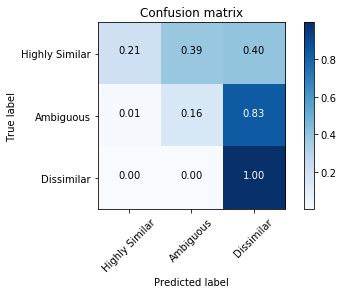

In [18]:
% matplotlib inline
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(ConfusionMats['F135_1.97d']['AvgB62.Regression']['Raw.Final'], ['Highly Similar', 'Ambiguous', 'Dissimilar'], True)

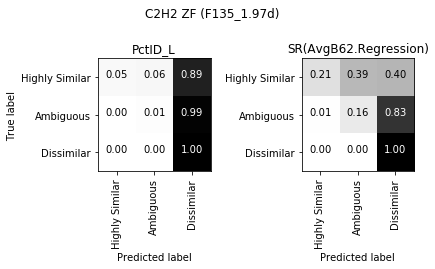

In [19]:
def plot_two_confusion_matricies(cm1, cm2, cmnames, classes,
                                normalize=False,
                                main_title='Confusion matrix',
                                cmap=plt.cm.Greys):
    """
    This function prints and plots two confusion matricies.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
        cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

    plt.subplot(1, 2, 1)
    plt.imshow(cm1, interpolation='nearest', cmap=cmap)
    plt.title(cmnames[0])
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm1.max() / 2.
    for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
        plt.text(j, i, format(cm1[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm1[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cm2, interpolation='nearest', cmap=cmap)
    plt.title(cmnames[1])
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm2.max() / 2.
    for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        plt.text(j, i, format(cm2[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm2[i, j] > thresh else "black")
    plt.tight_layout()
    #plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.suptitle(main_title)

CM_CurrentFam = ConfusionMats['F135_1.97d']
PerformanceSet = 'Raw.Final'
method_SR = 'AvgB62.Regression'
SR = CM_CurrentFam[method_SR][PerformanceSet]
method_Baseline = 'PctID_L'
Baseline = CM_CurrentFam[method_Baseline][PerformanceSet]           
classnames = ['Highly Similar', 'Ambiguous', 'Dissimilar']
plot_two_confusion_matricies(Baseline, SR, [method_Baseline, 'SR' + '(' + method_SR + ')'], classnames, True, 'C2H2 ZF (F135_1.97d)')

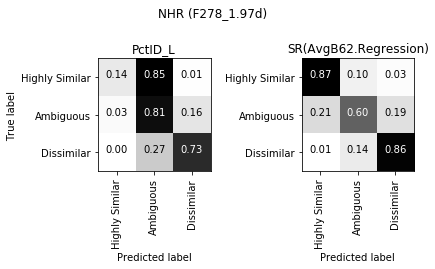

In [20]:
CM_CurrentFam = ConfusionMats['F278_1.97d']
PerformanceSet = 'Raw.Final'
method_SR = 'AvgB62.Regression'
SR = CM_CurrentFam[method_SR][PerformanceSet]
method_Baseline = 'PctID_L'
Baseline = CM_CurrentFam[method_Baseline][PerformanceSet]           
classnames = ['Highly Similar', 'Ambiguous', 'Dissimilar']
plot_two_confusion_matricies(Baseline, SR, [method_Baseline, 'SR' + '(' + method_SR + ')'], classnames, True, 'NHR (F278_1.97d)')

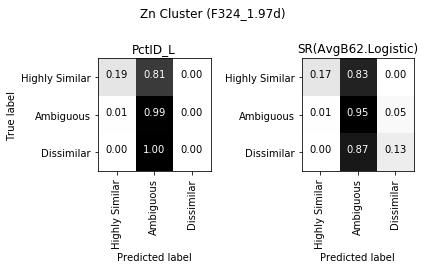

In [21]:
CM_CurrentFam = ConfusionMats['F324_1.97d']
PerformanceSet = 'Raw.Final'
method_SR = 'AvgB62.Logistic'
SR = CM_CurrentFam[method_SR][PerformanceSet]
method_Baseline = 'PctID_L'
Baseline = CM_CurrentFam[method_Baseline][PerformanceSet]           
classnames = ['Highly Similar', 'Ambiguous', 'Dissimilar']
plot_two_confusion_matricies(Baseline, SR, [method_Baseline, 'SR' + '(' + method_SR + ')'], classnames, True, 'Zn Cluster (F324_1.97d)')